In [236]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import loguniform
import math
import pickle
import joblib

#modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

#metrics 
from sklearn.metrics import accuracy_score,precision_score, recall_score, precision_recall_curve,f1_score, log_loss, make_scorer
from sklearn import preprocessing,metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df=pd.read_pickle('data/df')

In [3]:
df.shape #(762106, 42)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 42 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             762106 non-null  int64  
 1   ward_id                                 762106 non-null  int64  
 2   vdcmun_id                               762106 non-null  int64  
 3   vdcmun_name                             762106 non-null  object 
 4   district_id                             762106 non-null  int64  
 5   district_name                           762106 non-null  object 
 6   count_floors_pre_eq                     762106 non-null  int64  
 7   age_building                            762106 non-null  int64  
 8   plinth_area_sq_ft                       762106 non-null  int64  
 9   height_ft_pre_eq                        762106 non-null  int64  
 10  land_surface_condition                  7621

In [4]:
#only a handful of rows with na values so drop these 38 rows
df.isnull().sum().sort_values(ascending=False)

technical_solution_proposed               12
damage_grade                              12
has_secondary_use                         10
count_families                             2
plan_configuration                         1
position                                   1
has_secondary_use_agriculture              0
has_superstructure_bamboo                  0
has_superstructure_rc_non_engineered       0
has_superstructure_rc_engineered           0
has_superstructure_other                   0
has_secondary_use_hotel                    0
has_superstructure_cement_mortar_brick     0
has_secondary_use_rental                   0
has_secondary_use_institution              0
has_secondary_use_school                   0
has_secondary_use_industry                 0
has_secondary_use_health_post              0
has_secondary_use_gov_office               0
has_secondary_use_use_police               0
has_secondary_use_other                    0
has_superstructure_timber                  0
building_i

In [6]:
df.dropna(inplace=True) #(762093, 42)
df.shape

(762093, 42)

In [7]:
# drop rows with missing year data
df.drop(df[df['age_building']==999].index,inplace=True)
df.shape

(758949, 42)

One Hot Encoding

In [8]:
df.columns[df.dtypes == 'object']

Index(['vdcmun_name', 'district_name', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'damage_grade',
       'technical_solution_proposed'],
      dtype='object')

In [9]:
transformed_df=pd.get_dummies(data=df, columns=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration'])

In [10]:
#clean up names
transformed_df.columns = transformed_df.columns.str.replace(' ', '_')

Create training and testing data

In [11]:
y= transformed_df['damage_grade']
X =transformed_df.drop(labels = ['damage_grade','technical_solution_proposed','building_id','ward_id','vdcmun_id',
       'vdcmun_name','district_id','district_name'], axis = 1)


In [241]:
print(X.shape)
print(y.shape)

(758949, 61)
(758949,)


In [243]:
X.to_pickle('data/X')
y.to_pickle('data/y')

## Modelling


### Logistic Regression

In [12]:
#Stratify to ensure that there are even proportions of each grade in the test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 88, stratify = transformed_df['damage_grade'],shuffle=True)   

In [13]:
# Visualise proportions on train ,val and test
pd.merge(y_train.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="train"),
             y_test.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="test"),
             on = "index",
             how = "left")

,index,train,test
0,Grade 5,0.361864,0.361862
1,Grade 4,0.241332,0.241333
2,Grade 3,0.178940,0.178945
3,Grade 2,0.114510,0.114507
4,Grade 1,0.103353,0.103353


In [14]:
#scale data 
std = StandardScaler()
std.fit(X_train.values)
X_train_scaled = std.transform(X_train.values)
X_test_scaled= std.transform(X_test.values)

In [ ]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

Multinomial Logistic Regression Grid Search

In [26]:
#create baseline model
from sklearn.metrics import log_loss, make_scorer
#https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

# define model
model = LogisticRegression()

space = dict()
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=['Grade 1','Grade 2','Grade 3','Grade 4','Grade 5'])
search = GridSearchCV(model, space, scoring=LogLoss, n_jobs=-1, cv=3)

# execute search
result = search.fit(X_train_scaled, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Best Score: -1.3055859831394114
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#baseline model
#use tuned hyperparameters from gridsearch
logit_baseline = LogisticRegression(multi_class='multinomial',penalty='l2',solver='lbfgs', C=0.1)
logit_baseline.fit(X_train_scaled, y_train)

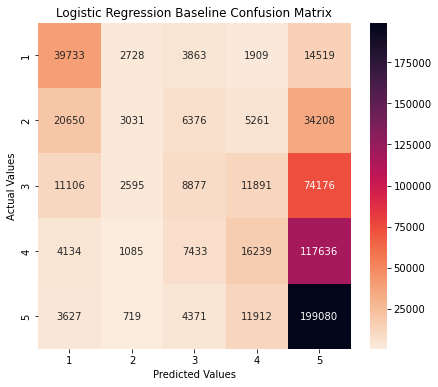

In [53]:
#baseline confusion matrix
y_pred=logit_baseline.predict(X_train_scaled)
cm=confusion_matrix(y_train,y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4','5'], 
                     columns = ['1','2','3','4','5'])
                     
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True,fmt='d',cmap='rocket_r')
plt.title('Logistic Regression Baseline Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

One vs Rest Logistic Regression Grid Search

In [33]:
# Find Optimal C by grid search 

tuned_parameters = [{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}]

log_reg_clf = OneVsRestClassifier(LogisticRegression())
logistic_gs = GridSearchCV(log_reg_clf, tuned_parameters,scoring = 'neg_log_loss', n_jobs=-1,cv=3)
logistic_gs.fit(X_train_scaled, y_train)

print(logistic_gs.best_estimator_)
print(logistic_gs.best_score_)
print(logistic_gs.best_params_)

OneVsRestClassifier(estimator=LogisticRegression(C=10))
-1.3076058094501235
{'estimator__C': 10}


Multinomial Logistic Regression with balanced class weighting

In [105]:
kfold = StratifiedKFold(n_splits=3, random_state=88, shuffle=True)

In [27]:
#use tuned hyperparameters from gridsearch with balanced class weighting

logit_balanced = LogisticRegression(multi_class='multinomial',penalty='l2',solver='lbfgs' C=0.1,class_weight ='balanced')
logit_balanced.fit(X_train_scaled, y_train)

cv_results =cross_val_score(logit_balanced, X_train_scaled, y_train, cv=kfold, scoring='neg_log_loss')
cv_results.mean(), cv_results.std()

/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

(-1.3799700110052804, 0.0012606004072732255)

In [ ]:
# grid search using balanced Logistic Regression 
model = LogisticRegression(class_weight='balanced')

#define search space
space = dict()
space['solver'] = ['saga']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = [ 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
search = GridSearchCV(model, space, scoring='neg_log_loss', n_jobs=-1, cv=3)
# execute search
result = search.fit(X_train_scaled, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#retuning improves score minimally, while increasing the run time, so keep the baseline hyperparameters

One vs Rest (balanced)

In [28]:
#use tuned hyperparameters from gridsearch with class weighting
logit_ovr = LogisticRegression(multi_class='ovr',C=10,class_weight ='balanced')
logit_ovr.fit(X_train_scaled, y_train)

cv_results =cross_val_score(logit_ovr, X_train_scaled, y_train, cv=kfold, scoring='neg_log_loss')
cv_results.mean(), cv_results.std()

(-1.4109678971965807, 0.00043179394259477754)

## SMOTE

In [29]:
oversample=SMOTE() #63m
X_smote,y_smote=oversample.fit_resample(X_train_scaled,y_train)
np.save('data/X_smote', X_smote)
np.save('data/y_smote', y_smote)

Class=Grade 5, n=219709 (28.949%)
Class=Grade 2, n=219709 (28.949%)
Class=Grade 3, n=219709 (28.949%)
Class=Grade 4, n=219709 (28.949%)
Class=Grade 1, n=219709 (28.949%)


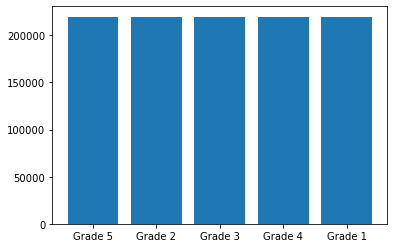

In [29]:
counter = Counter(y_smote)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [17]:
X_smote=np.load('data/X_smote.npy', allow_pickle=True)
y_smote=np.load('data/y_smote.npy', allow_pickle=True)
print(len(X_smote),len(y_smote))

In [28]:
#use tuned hyperparameters from gridsearch with SMOTE
logit_smote = LogisticRegression(multi_class='multinomial',penalty='l2',solver='lbfgs', C=0.1)
logit_smote.fit(X_smote, y_smote)

cv_results =cross_val_score(logit_smote, X_smote, y_smote, cv=kfold, scoring='neg_log_loss')
cv_results.mean(), cv_results.std()

/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

(-1.3731182269818067, 0.0010846157126073114)

### Binary model

In [ ]:
y_binary=transformed_df['technical_solution_proposed']

In [ ]:
# make y into binary 
mapping = {"Reconstruction": 1,
                    "Major repair" : 1,
                    "Minor repair" : 0,
                    "No need" : 0,}
y_binary['major_repair'] = y_binary.map(mapping) 


In [ ]:
y_binary=y_binary['major_repair']

In [ ]:
#Stratify to ensure that there are even proportions of each grade in the test and train data
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary,test_size = 0.2, random_state = 88,stratify=y,shuffle=True)     
X_train, X_val, y_binary_train, y_binary_val = train_test_split(X_train, y_binary_train,test_size = 0.25, random_state = 88,stratify=y,shuffle=True)                                  

In [ ]:
# Visualise proportions on train and test
pd.merge(y_binary_train.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="train"),
         y_binary_test.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="test"),
         on = "index",
         how = "left")

,index,train,val,test
0,1,0.786786,0.786926,0.786982
1,0,0.213214,0.213074,0.213018


In [ ]:
#scale data 
std = StandardScaler()
std.fit(X_train.values)
X_train_scaled = std.transform(X_train.values)
X_test_scaled= std.transform(X_test.values)

In [ ]:
#training
logit_binary= LogisticRegression()
logit_binary.fit(X_train_scaled, y_binary_train)
y_pred = logit_binary.predict(X_train_scaled)

print("Accuracy:",metrics.accuracy_score(y_binary_train, y_pred))
print("Precision:",metrics.precision_score(y_binary_train, y_pred))
print("Recall:",metrics.recall_score(y_binary_train, y_pred))
print("f1:",metrics.f1_score(y_binary_train, y_pred))


Accuracy: 0.8562669977168245
Precision: 0.8739691388178501
Recall: 0.955037510172361
f1: 0.912706698759026


In [ ]:
#validation
y_pred = logit_binary.predict(X_val_scaled) 

print("Accuracy:",metrics.accuracy_score(y_binary_val, y_pred))
print("Precision:",metrics.precision_score(y_binary_val, y_pred))
print("Recall:",metrics.recall_score(y_binary_val, y_pred))
print("f1:",metrics.f1_score(y_binary_val, y_pred))


Accuracy: 0.8569405099150141
Precision: 0.8748993056887491
Recall: 0.9547186002218548
f1: 0.9130678463124393


ROC AUC score =  0.8219223023926171


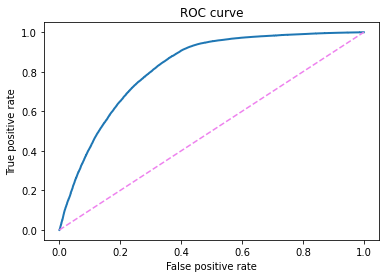

In [104]:
fpr, tpr, thresholds = roc_curve(y_binary_val, logit_binary.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_binary_val, logit_binary.predict_proba(X_val_scaled)[:,1]))

### Linear Regression 

In [57]:
# make y into numerical target
mapping = {"Grade 1" : 1,
                    "Grade 2" : 2,
                    "Grade 3" : 3,
                    "Grade 4" : 4,
                    "Grade 5" : 5}
y_num = y.map(mapping) 
y_num

0         3
1         5
2         2
3         2
4         1
         ..
762101    5
762102    5
762103    5
762104    5
762105    5
Name: damage_grade, Length: 758949, dtype: int64

In [58]:
#Stratify to ensure that there are even proportions of each grade in the test and train data
X_train, X_test, y_train_num, y_test_num = train_test_split(X, y_num,test_size = 0.2, random_state = 88, stratify = transformed_df['damage_grade'],shuffle=True)            

In [59]:
# Visualise proportions on train and test
pd.merge(y_train_num.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="train"),
         y_test_num.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="test"),
         on = "index",
         how = "left")

,index,train,test
0,5,0.361864,0.361862
1,4,0.241332,0.241333
2,3,0.178940,0.178945
3,2,0.114510,0.114507
4,1,0.103353,0.103353


In [51]:
#scale data 
std = StandardScaler()
std.fit(X_train.values)
X_train_scaled = std.transform(X_train.values)
X_test_scaled= std.transform(X_test.values)

In [117]:
#Linear Regression with Lasso Model

#optimize alpha by iterating
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train_num)
alpha = lasso_model.alpha_
print(alpha)

## refit LASSO model with optimized alpha
lasso_model = Lasso(alpha =alpha)
lasso_model.fit(X_train_scaled,y_train_num)

print(list(zip(X_train.columns, lasso_model.coef_)))

0.01
[('count_floors_pre_eq', 0.11768018130363365), ('age_building', 0.08256144557725198), ('plinth_area_sq_ft', -0.011091047380336881), ('height_ft_pre_eq', -0.0), ('has_superstructure_adobe_mud', 0.005069738295165502), ('has_superstructure_mud_mortar_stone', 0.2879409363715912), ('has_superstructure_stone_flag', 0.08779603188644193), ('has_superstructure_cement_mortar_stone', 0.0), ('has_superstructure_mud_mortar_brick', 0.0), ('has_superstructure_cement_mortar_brick', -0.10214436520552589), ('has_superstructure_timber', -0.07657521916324245), ('has_superstructure_bamboo', -0.02485113831272468), ('has_superstructure_rc_non_engineered', -0.018600153801665954), ('has_superstructure_rc_engineered', -0.04373939895543626), ('has_superstructure_other', -0.022420484925455647), ('count_families', 0.031950914087610756), ('has_secondary_use', -0.01280114410061808), ('has_secondary_use_agriculture', -0.0), ('has_secondary_use_hotel', -0.0), ('has_secondary_use_rental', -0.014007897477180545), (

In [118]:
y_pred = lasso_model.predict(X_train_scaled)

y_pred_whole = [round(num) for num in y_pred]
mapping={0:1, 6:5} # force 0 and 6s into correct categories
y_pred_whole = [mapping.get(number,number)for number in y_pred_whole]

print("f1:",metrics.f1_score(y_num, y_pred_whole, average='micro'))
print("RMSE:",math.sqrt(metrics.mean_squared_error(y_num, y_pred_whole)))

f1: 0.2767961257845605
RMSE: 1.2640651908799805


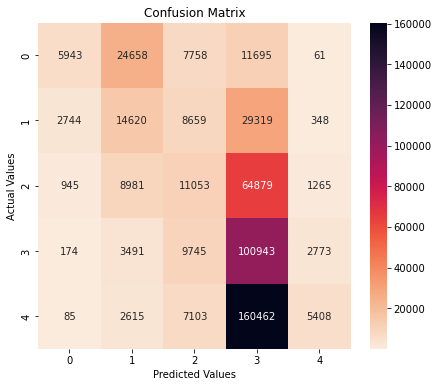

In [111]:
#linear regression confusion matrix
cm=confusion_matrix(y_train_num,y_pred_whole)

cm_df = pd.DataFrame(cm)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True,fmt='d',cmap='rocket_r')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [106]:
#Linear Regression with SMOTE

#optimize alpha by iterating
alphavec = 10**np.linspace(-2,2,200)
lasso_model_smote = LassoCV(alphas = alphavec, cv=5)
lasso_model_smote.fit(X_smote, y_smote_num)
alpha = lasso_model_smote.alpha_
print(alpha)

## refit LASSO model with optimized alpha
lasso_model_smote = Lasso(alpha =alpha)
lasso_model_smote.fit(X_smote,y_smote_num)

print(list(zip(X_train.columns, lasso_model_smote.coef_)))

0.01
[('count_floors_pre_eq', 0.15342670374504508), ('age_building', 0.1441595491037242), ('plinth_area_sq_ft', -0.0010714803894210977), ('height_ft_pre_eq', -0.0), ('has_superstructure_adobe_mud', 0.01668295013514882), ('has_superstructure_mud_mortar_stone', 0.2943076180687505), ('has_superstructure_stone_flag', 0.08991022578194037), ('has_superstructure_cement_mortar_stone', 0.0), ('has_superstructure_mud_mortar_brick', 0.0025912710747782344), ('has_superstructure_cement_mortar_brick', -0.05875540402790027), ('has_superstructure_timber', -0.09423534857657184), ('has_superstructure_bamboo', -0.019242702969782442), ('has_superstructure_rc_non_engineered', -0.016931307912020445), ('has_superstructure_rc_engineered', -0.034770782336488566), ('has_superstructure_other', -0.023095368858294583), ('count_families', 0.04405693394022389), ('has_secondary_use', -0.0), ('has_secondary_use_agriculture', 0.0), ('has_secondary_use_hotel', -0.00534538766797553), ('has_secondary_use_rental', -0.01616

In [116]:
y_pred = lasso_model.predict(X_smote)

y_pred_whole = [round(num) for num in y_pred]
mapping={0:1, 6:5} # force 0 and 6s into correct categories
y_pred_whole = [mapping.get(number,number)for number in y_pred_whole]

print("f1:",metrics.f1_score(y_smote_num, y_pred_whole, average='micro'))
print("RMSE:",math.sqrt(metrics.mean_squared_error(y_smote_num, y_pred_whole)))

f1: 0.29076824344928975
RMSE: 1.1856480324848981


## Random Forest Classifier

In [43]:
#random forest classifier with SMOTE
rfc = RandomForestClassifier() 

param_grid = { 
    'n_estimators': [200,300],
    'max_depth' : [10,20]
}

CV_rfc_smote = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring ='neg_log_loss',n_jobs=-1,cv=3)
CV_rfc_smote.fit(X_smote, y_smote)

print(CV_rfc_smote.best_params_)
print(CV_rfc_smote.best_score_)

{'max_depth': 20, 'n_estimators': 300}
-1.2410468522618519


In [205]:
#use tuned hyperparameters from gridsearch with SMOTE
rfc_smote = RandomForestClassifier(n_estimators=300, max_depth =20, n_jobs=-1)
rfc_smote.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=20, n_estimators=300, n_jobs=-1)

In [206]:
pred = rfc_smote.predict_proba(X_smote)
log_loss(y_smote,pred)

1.1568193796295487

In [249]:
y_smote

array(['Grade 5', 'Grade 2', 'Grade 3', ..., 'Grade 4', 'Grade 4',
       'Grade 4'], dtype=object)

In [247]:
pred

array([[0.06910609, 0.14885838, 0.21917971, 0.28885419, 0.27400164],
       [0.13443118, 0.18504994, 0.22126308, 0.24879674, 0.21045906],
       [0.0744709 , 0.1441678 , 0.20516075, 0.29011488, 0.28608568],
       ...,
       [0.02628008, 0.12866354, 0.24999244, 0.38463937, 0.21042457],
       [0.05884199, 0.15398209, 0.24022057, 0.3084057 , 0.23854965],
       [0.01111998, 0.07851465, 0.18839749, 0.35037228, 0.37159561]])

In [207]:
joblib.dump(rfc_smote, 'models/rfc_smote')
#rfc_smote = joblib.load('models/rfc_smote')

['models/rfc_smote']

In [239]:
filename = 'models/rfc_smote_pkl.sav'
pickle.dump(rfc_smote, open(filename, 'wb'))

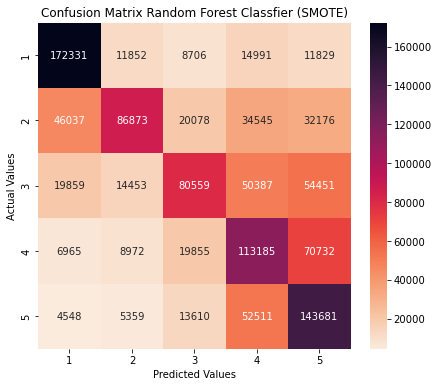

In [47]:
y_pred = CV_rfc_smote.predict(X_smote)

cm=confusion_matrix(y_smote,y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4','5'], 
                     columns = ['1','2','3','4','5'])
                     
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True,fmt='d',cmap='rocket_r')
plt.title('Confusion Matrix Random Forest Classfier (SMOTE)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Random Forest Regressor

In [72]:
#random forest regressor
rfr = RandomForestRegressor()

param_grid = {
    'max_depth': [10,20,50],
    'n_estimators': [10,50,100]
}
CV_rfr= GridSearchCV(estimator=rfr, param_grid=param_grid, scoring ='neg_root_mean_squared_error',n_jobs=-1,cv=3)
CV_rfr.fit(X_train_scaled, y_train_num)

print(CV_rfr.best_params_)
print(CV_rfr.best_score_)


{'max_depth': 20, 'n_estimators': 50}
-1.042721590293561


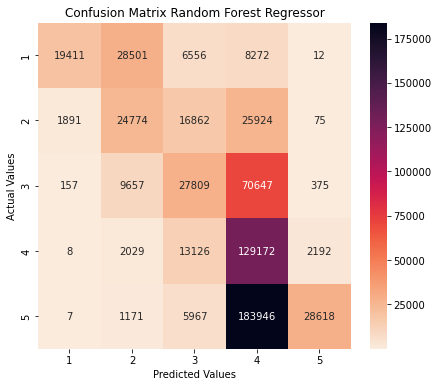

In [85]:
#Confusion Matrix Random Forest Regressor
y_pred = CV_rfr.predict(X_train_scaled)
y_pred_whole = [round(num) for num in y_pred]
mapping={0:1, 6:5} # force 0 and 6s into correct categories
y_pred_whole = [mapping.get(number,number)for number in y_pred_whole]
cm=confusion_matrix(y_train_num,y_pred_whole)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4','5'], 
                     columns = ['1','2','3','4','5'])
                     
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True,fmt='d',cmap='rocket_r')
plt.title('Confusion Matrix Random Forest Regressor')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
y_smote
mapping = {"Grade 1" : 1,
                    "Grade 2" : 2,
                    "Grade 3" : 3,
                    "Grade 4" : 4,
                    "Grade 5" : 5}
y_smote_num = [mapping[x]for x in y_smote]

In [101]:
#use tuned hyperparameters from gridsearch with SMOTE
rfr_smote = RandomForestRegressor(n_estimators=50, max_depth =20, n_jobs=-1)

cv_results =cross_val_score(rfr_smote, X_smote, y_smote_num, cv=kfold, scoring='neg_root_mean_squared_error')
cv_results.mean(), cv_results.std()

rfr_smote.fit(X_smote, y_smote_num)

(-0.997653825463142, 0.002816541325273567)

In [193]:
joblib.dump(rfr_smote, 'models/rfr_smote')
rfr_smote = joblib.load('models/rfr_smote')

array([3.93172632, 3.15641332, 3.43940561, ..., 3.15765414, 3.13090767,
       4.01517491])

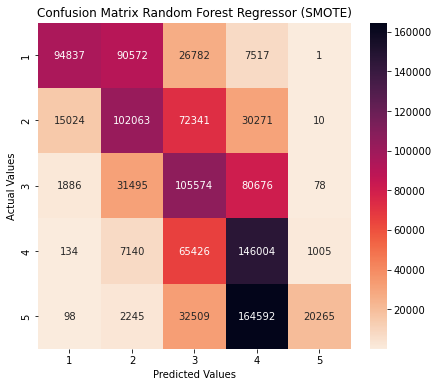

In [194]:
#Confusion Matrix Random Forest Regressor
y_pred = rfr_smote.predict(X_smote)
y_pred_whole = [round(num) for num in y_pred]
mapping={0:1, 6:5} # force 0 and 6s into correct categories
y_pred_whole = [mapping.get(number,number)for number in y_pred_whole]
cm=confusion_matrix(y_smote_num,y_pred_whole)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4','5'], 
                     columns = ['1','2','3','4','5'])
                     
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True,fmt='d',cmap='rocket_r')
plt.title('Confusion Matrix Random Forest Regressor (SMOTE)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## XG BOOST

In [128]:
#have to convert numbers as integers starting from 0 (0,1,2,...) 
y_train_num_xgb= y_train_num-1
y_smote_num_xgb= [x-1 for x in y_smote_num]

In [154]:
#Split data into 3: 60% train, 20% validation, 20% test
X_smote_train, X_smote_val, y_smote_num_train, y_smote_num_val = train_test_split(X_smote, y_smote_num_xgb, test_size=0.25, random_state=88)

In [160]:
xgb = XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective='multi:softprob',  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_smote_train,y_smote_num_train),(X_smote_val,y_smote_num_val)] #tracking train/validation error as we go
fit_model = xgb.fit( 
                    X_smote_train, y_smote_num_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )
#[500] validation_0-mlogloss:1.27398	validation_1-mlogloss:1.27699 
#train, validation sets started diverging at this point so chose n_estimator = 500

[0]	validation_0-mlogloss:1.58693	validation_1-mlogloss:1.58674
[1]	validation_0-mlogloss:1.56826	validation_1-mlogloss:1.56817
[2]	validation_0-mlogloss:1.55124	validation_1-mlogloss:1.55083
[3]	validation_0-mlogloss:1.53498	validation_1-mlogloss:1.53483
[4]	validation_0-mlogloss:1.52093	validation_1-mlogloss:1.52083
[5]	validation_0-mlogloss:1.50859	validation_1-mlogloss:1.50817
[6]	validation_0-mlogloss:1.49755	validation_1-mlogloss:1.49736
[7]	validation_0-mlogloss:1.48728	validation_1-mlogloss:1.48722
[8]	validation_0-mlogloss:1.47833	validation_1-mlogloss:1.47807
[9]	validation_0-mlogloss:1.47020	validation_1-mlogloss:1.46994
[10]	validation_0-mlogloss:1.46252	validation_1-mlogloss:1.46234
[11]	validation_0-mlogloss:1.45601	validation_1-mlogloss:1.45565
[12]	validation_0-mlogloss:1.44971	validation_1-mlogloss:1.44951
[13]	validation_0-mlogloss:1.44423	validation_1-mlogloss:1.44402
[14]	validation_0-mlogloss:1.43912	validation_1-mlogloss:1.43886
[15]	validation_0-mlogloss:1.43407	

KeyboardInterrupt: 

In [163]:
#refit model with chosen parameters to full training set
xgb = XGBClassifier( 
                       n_estimators=500, #chosen n_estimator
                       max_depth=3,
                       objective='multi:softprob',
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )
xgb.fit(X_smote, y_smote_num_xgb)

/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:52:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [173]:
pred = xgb.predict_proba(X_smote_train)
log_loss(y_smote_num_train,pred)

1.2363962353940752

In [ ]:
#Split data into 3: 60% train, 20% validation, 20% test
X_smote_train, X_smote_val, y_smote_num_train, y_smote_num_val = train_test_split(X_smote, y_smote_num_xgb, test_size=0.25, random_state=88)

In [179]:
xgr = XGBRegressor( 
                       n_estimators=1000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8,
                       njobs=-1
)

In [180]:

eval_set=[(X_smote_train,y_smote_num_train),(X_smote_val,y_smote_num_val)] #tracking train/validation error as we go
fit_model = xgr.fit( 
                    X_smote_train, y_smote_num_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=5,
                    verbose=True) #gives output log as below

#[500]	validation_0-rmse:1.02099	validation_1-rmse:1.02171
#train, validation sets started diverging at this point so chose n_estimator = 500

[21:41:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "njobs" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.92639	validation_1-rmse:1.92596
[1]	validation_0-rmse:1.80642	validation_1-rmse:1.80642
[2]	validation_0-rmse:1.70195	validation_1-rmse:1.70213
[3]	validation_0-rmse:1.61297	validation_1-rmse:1.61261
[4]	validation_0-rmse:1.53670	validation_1-rmse:1.53667
[5]	validation_0-rmse:1.47381	validation_1-rmse:1.47369
[6]	validation_0-rmse:1.41764	validation_1-rmse:1.41752
[7]	validation_0-rmse:1.37079	validation_1-rmse:1.37114
[8]	validation_0-rmse:1.33191	validation_1-rmse:1.33188
[9]	validation_0-rmse:1.29834	validation_1-rmse:1.29823
[10]	validation_0-r

KeyboardInterrupt: 

## Comparing between final 2 models

In [218]:
y_pred = rfr_smote.predict(X_smote)

y_pred_whole = [round(num) for num in y_pred]
mapping={0:1, 6:5} # force 0 and 6s into correct categories
y_pred_whole = [mapping.get(number,number)for number in y_pred_whole]

print("Accuracy:",accuracy_score(y_pred_whole, y_smote_num))
print("Precision:",precision_score(y_pred_whole, y_smote_num,average='micro'))
print("Recall:",recall_score(y_pred_whole, y_smote_num,average='micro'))
print("f1:",f1_score(y_pred_whole, y_smote_num,average='micro'))

Accuracy: 0.42669440032042383
Precision: 0.42669440032042383
Recall: 0.42669440032042383
f1: 0.42669440032042383


In [221]:
y_pred = rfc_smote.predict(X_smote)

print("Accuracy:",accuracy_score(y_pred, y_smote))
print("Precision:",precision_score(y_pred, y_smote,average='micro'))
print("Recall:",recall_score(y_pred, y_smote,average='micro'))
print("f1:",f1_score(y_pred, y_smote,average='micro'))

Accuracy: 0.5426714426810008
Precision: 0.5426714426810008
Recall: 0.5426714426810008
f1: 0.5426714426810008
